In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import time

In [7]:
# 1) Load the data
# Assumes the .npz is in your working directory. Adjust the path if necessary.

#data = np.load('datasets/eye_tracking_preprocessed_400frames_test.npz', allow_pickle=True)
#events, centers = data["events"], data["centers"]

data = np.load('datasets/eye_tracking_bs100.npz')['data']


In [8]:
data.shape

(5000, 80, 106, 2)

In [9]:
n_frames, H, W, n_ch = data.shape
print(f"Loaded data with {n_frames} frames, {H}×{W} pixels, {n_ch} channels")

Loaded data with 5000 frames, 80×106 pixels, 2 channels


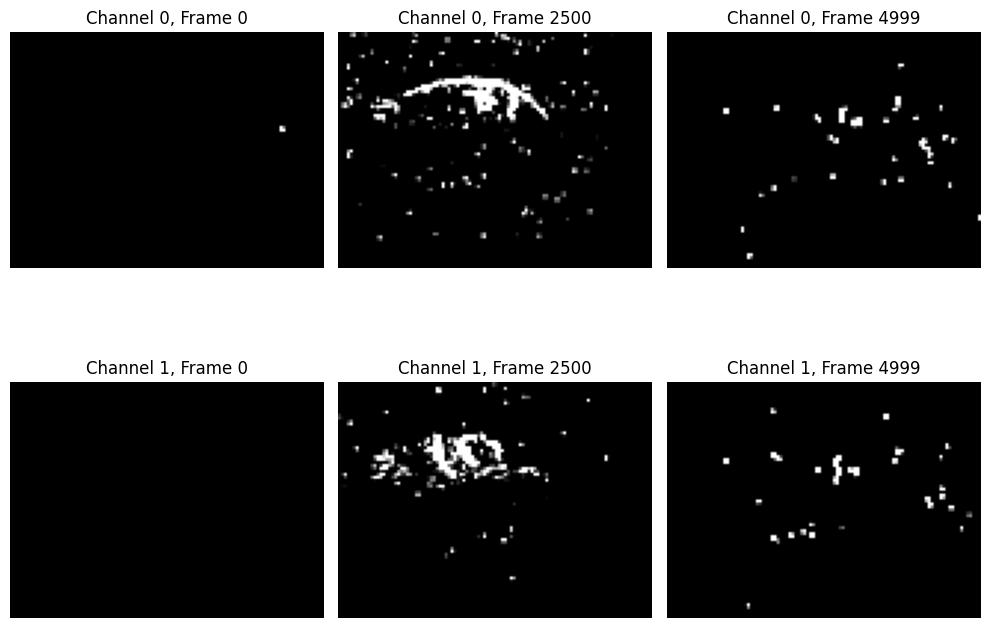

In [10]:
fig, axes = plt.subplots(n_ch, 3, figsize=(10, 4*n_ch))
frame_idxs = [0, n_frames//2, n_frames-1]
for ch in range(n_ch):
    for col, f in enumerate(frame_idxs):
        ax = axes[ch, col] if n_ch > 1 else axes[col]
        im = ax.imshow(data[f, :, :, ch], cmap='gray', 
                       vmin=np.nanmin(data[...,ch]), vmax=np.nanmax(data[...,ch]))
        ax.set_title(f'Channel {ch}, Frame {f}')
        ax.axis('off')
fig.tight_layout()
plt.show()

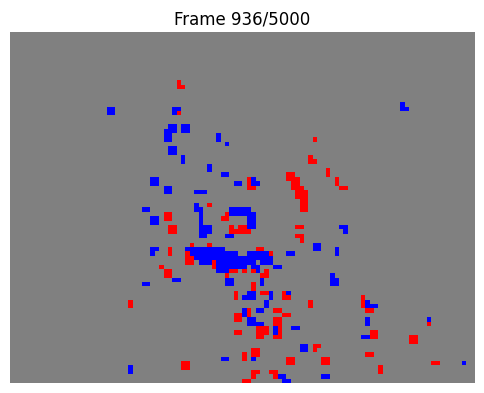

In [ ]:
# 2) Choose a color for each channel
if n_ch == 2:
    # e.g. channel 0 = red, channel 1 = blue
    colors = np.array([[255, 0, 0], [0, 0, 255]], dtype=np.uint8)
else:
    # fallback: pick from matplotlib’s tab10 palette
    import matplotlib
    cmap = matplotlib.cm.get_cmap('tab10', n_ch)
    colors = (cmap(range(n_ch))[:, :3] * 255).astype(np.uint8)

# 3) Create one figure & axis to reuse
fig, ax = plt.subplots(figsize=(6, 6))

# 4) Loop over frames, updating in place
for f in range(n_frames):
    # 4a) start from a mid-gray background
    frame_vis = np.full((H, W, 3), 128, dtype=np.uint8)
    
    # 4b) paint each channel’s “events” on top
    for ch in range(n_ch):
        mask = data[f, :, :, ch] > 0   # assuming >0 marks an event
        frame_vis[mask] = colors[ch]
    
    # 4c) update the image
    ax.clear()
    ax.imshow(frame_vis)
    ax.set_title(f'Frame {f+1}/{n_frames}')
    ax.axis('off')
    
    # 4d) redraw the same window
    clear_output(wait=True)
    display(fig)
    time.sleep(0.01)   # adjust playback speed

# 5) close when done
plt.close(fig)